# TimesFM Time Series Prediction Playbook

[Huggingface](https://huggingface.co/google/timesfm-2.5-200m-pytorch)

In [1]:
def extend_path():
    """Extend notebooks system path config to import relative packages."""
    import sys
    from pathlib import Path

    parent_folder = str(Path.cwd().parent)
    print(f"Adding {parent_folder} to sys.path")
    if parent_folder not in sys.path:
        sys.path.insert(0, parent_folder)


extend_path()

Adding /Users/lukaskurz/University/fusiontimeseries to sys.path


In [2]:
import torch
import timesfm

from playground.utils import plot_forecast

In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

MODEL_HF_REPO_ID = "google/timesfm-2.5-200m-pytorch"
N_TIMESERIES = 1

Using device: cpu


In [15]:
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained(
    MODEL_HF_REPO_ID, torch_compile=True
)

config.json:   0%|          | 0.00/475 [00:00<?, ?B/s]

Downloaded.
Compiling model...


In [16]:
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=256,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True,
        fix_quantile_crossing=True,
    )
)

In [17]:
torch.manual_seed(42)
context = torch.rand((N_TIMESERIES, 128), device=DEVICE)
context.shape

torch.Size([1, 128])

In [18]:
point_forecast, quantile_forecast = model.forecast(
    horizon=64,
    inputs=[
        context.squeeze(0),  # type: ignore[arg-type]
    ],
)

In [19]:
point_forecast.shape, quantile_forecast.shape, quantile_forecast[0, 0, :]

((1, 64),
 (1, 64, 10),
 array([0.35130984, 0.04801778, 0.11389759, 0.16898724, 0.24761978,
        0.31812212, 0.3831707 , 0.46193016, 0.5497031 , 0.6812054 ],
       dtype=float32))

> quantile dimension for timesFM: mean, then 10th to 90th quantiles.

In [20]:
quantiles = quantile_forecast[:, :, 1:]
mean = quantile_forecast[:, :, 0]
quantiles.shape, mean.shape

((1, 64, 9), (1, 64))

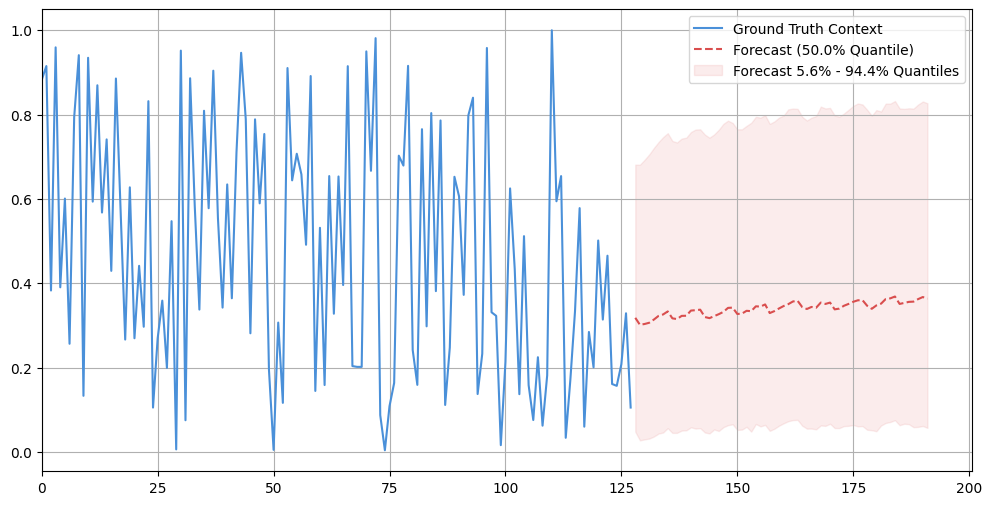

In [21]:
plot_forecast(
    ctx=context,
    quantile_fc=torch.from_numpy(quantiles),
    real_future_values=None,
    batch_idx=0,
)